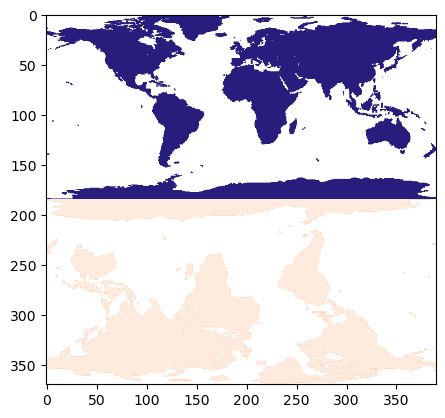

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

shape = [32,64,64]
data = np.zeros(shape)

p = [16,24,32]
X = np.meshgrid(*[np.arange(n) for n in shape], indexing='ij')
d = np.sqrt(sum([np.square(X[k]-p[k]) for k in range(3)]))
plt.imshow(d[16,:,:]<10)

from skimage import io
f0 = io.imread('../data/earth.png')
# dfs
f = np.concatenate([f0, np.flip(f0)])
plt.imshow(f)
#


(512, 512)

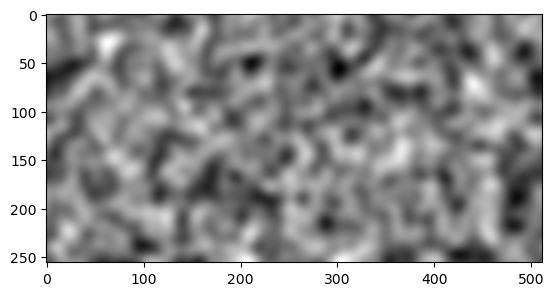

In [2]:
#f0 = io.imread('../data/earth.png')[:,:,0]
f0 = np.random.normal(0,1,size=(256,512))
# create the double fourier sphere
f = np.concatenate([f0, np.flip(f0)])
# filter the sphere
F = np.fft.fftn(f)
G = np.exp(-1000*np.square(np.stack(np.meshgrid(*[np.fft.fftfreq(n) for n in F.shape]),axis=0)).sum(axis=0))
f = np.real(np.fft.ifftn(F * G))
f0 = f[0:f.shape[0]//2,:]
plt.imshow(f0,cmap='gray')
plt.show()

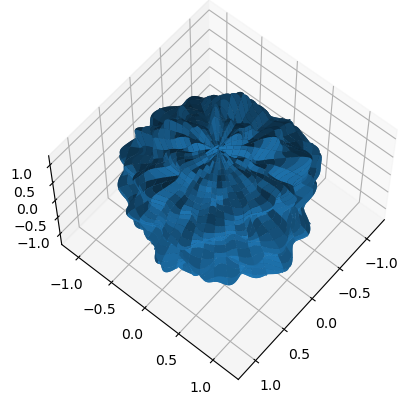

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
az,el = np.meshgrid(np.linspace(-math.pi,math.pi,f0.shape[1]),np.linspace(0,math.pi,f0.shape[0]))
R  = 1 + 2*f0
x = R*np.cos(az)*np.sin(el)
y = R*np.sin(az)*np.sin(el)
z = R*np.cos(el)
ax.plot_surface(x, y, z)
ax.view_init(elev=60, azim=40)
plt.show()

